## Import Libraries

In [1]:
import torch
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model import LitResNet, CIFAR10DataModule

/home/songc/miniconda3/envs/optforget/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up Environment

In [2]:
sns.set_style("whitegrid")
pl.seed_everything(42, workers=True)
PRETRAINED_CKPT_PATH = 'checkpoints/pretrained-best.ckpt'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Setting up data modules...")
data_module = CIFAR10DataModule(batch_size=256)
data_module.setup() 
val_loaders_A_and_B = data_module.val_dataloader()
print("✅ Data modules are ready.")

class ForgettingTracker(pl.Callback):
    def __init__(self):
        self.history = []
        self.epoch = 0

    def on_validation_epoch_end(self, trainer, pl_module):
        acc_A = trainer.callback_metrics.get('val_acc_A')
        acc_B = trainer.callback_metrics.get('val_acc_B')
        
        if acc_A is not None and acc_B is not None:
            self.history.append({
                'epoch': self.epoch,
                'Task A Acc': acc_A.item() * 100,
                'Task B Acc': acc_B.item() * 100,
            })
        self.epoch = self.epoch + 1
forgetting_tracker = ForgettingTracker()

Seed set to 42


Setting up data modules...
✅ Data modules are ready.


## Train on Task A

In [3]:
print("\n--- Phase 1: Pre-training on Task A (classes 0-4) ---")
model = LitResNet(learning_rate=1e-3, datamodule=data_module, optimizer_name='AdamW')
trainer_pretrain = pl.Trainer(
    max_epochs=5,
    accelerator='auto',
    callbacks=[forgetting_tracker],
    deterministic=True,
    enable_checkpointing=False,
    logger=False,
    enable_progress_bar=True
)
trainer_pretrain.fit(
    model, 
    train_dataloaders=data_module.train_dataloader(task='A'),
    val_dataloaders=val_loaders_A_and_B
)
print("\n✅ Pre-training on Task A finished.")

Trainer will use only 1 of 5 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=5)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Phase 1: Pre-training on Task A (classes 0-4) ---


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | LeNet5             | 62.1 K | train
1 | criterion    | CrossEntropyLoss   | 0      | train
2 | accuracy_A   | MulticlassAccuracy | 0      | train
3 | accuracy_B   | MulticlassAccuracy | 0      | train
  | other params | n/a                | 62.1 K | n/a  
------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.496     Total estimated model params size (MB)
19 

Epoch 0:   3%|▎         | 3/98 [00:00<00:09,  9.96it/s]                    

/home/songc/miniconda3/envs/optforget/lib/python3.10/site-packages/pytorch_lightning/core/module.py:520: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 4: 100%|██████████| 98/98 [00:03<00:00, 31.82it/s, val_loss_A=0.745, val_loss_B=11.50]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 98/98 [00:03<00:00, 31.78it/s, val_loss_A=0.745, val_loss_B=11.50]

✅ Pre-training on Task A finished.


## Train on Task B

In [4]:
print("\n\n--- Phase 2: Fine-tuning on Task B with SGD ---")
model.hparams.learning_rate = 1e-2
model.hparams.optimizer_name = 'SGD'
forgetting_tracker.epoch = forgetting_tracker.epoch - 1
trainer_finetune = pl.Trainer(
    max_epochs=5,
    accelerator='auto',
    callbacks=[forgetting_tracker],
    deterministic=True,
    logger=False,
    enable_progress_bar=True
)

trainer_finetune.fit(
    model, 
    train_dataloaders=data_module.train_dataloader(task='B'), 
    val_dataloaders=val_loaders_A_and_B
)
print("\n✅ Fine-tuning finished.")



--- Phase 2: Fine-tuning on Task B with SGD ---


Trainer will use only 1 of 5 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=5)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/songc/miniconda3/envs/optforget/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/songc/yxqian/optim-forget/experiments/cifar10/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 

Epoch 4: 100%|██████████| 98/98 [00:03<00:00, 31.36it/s, val_loss_A=8.340, val_loss_B=0.724]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 98/98 [00:07<00:00, 13.50it/s, val_loss_A=8.340, val_loss_B=0.724]

✅ Fine-tuning finished.


## Plot the Results


--- Phase 3: Visualizing the results ---


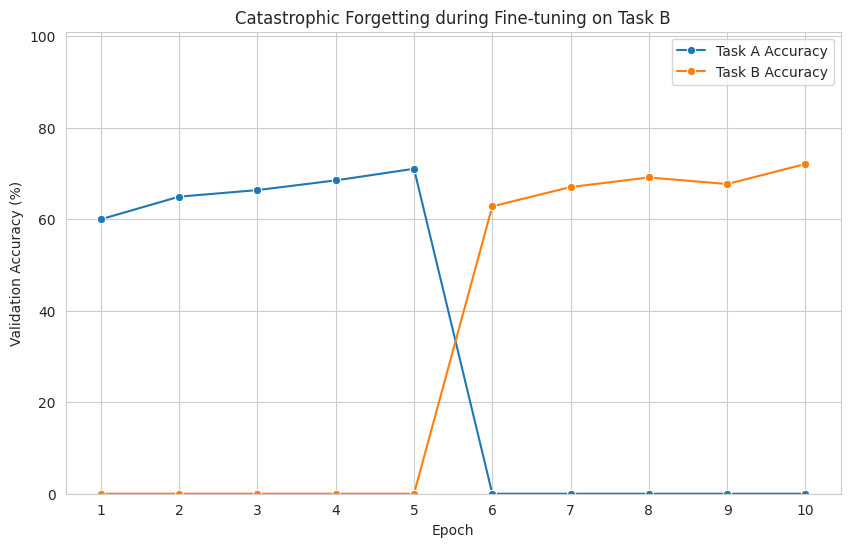


📊 Visualization complete.

Final Performance:
   epoch  Task A Acc  Task B Acc
0      1       60.00        0.00
1      2       64.94        0.00
2      3       66.38        0.00
3      4       68.50        0.00
4      5       71.04        0.00
5      6        0.00       62.82
6      7        0.00       67.04
7      8        0.00       69.14
8      9        0.00       67.70
9     10        0.00       72.08


In [5]:
print("\n--- Phase 3: Visualizing the results ---")
history_df = pd.DataFrame(forgetting_tracker.history)

if not history_df.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=history_df, x='epoch', y='Task A Acc', marker='o', label='Task A Accuracy')
    sns.lineplot(data=history_df, x='epoch', y='Task B Acc', marker='o', label='Task B Accuracy')

    plt.title('Catastrophic Forgetting during Fine-tuning on Task B')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.xticks(history_df['epoch'].unique())
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 101)
    plt.show()

    print("\n📊 Visualization complete.")
    print("\nFinal Performance:")
    print(history_df.round(2))
else:
    print("No history recorded to visualize.")